In [81]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
import mlflow
import mlflow.sklearn

In [82]:
class SentimentAnalysis:
    def get_sentiment(self, text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity, analysis.sentiment.subjectivity

    def process_data(self, df):
        df['ts'] = pd.to_datetime(df['ts'], unit='s')

        # Group messages by day since the start of the training
        df['day'] = df['ts'].dt.date
        grouped_data = df.groupby('day')['cleaned_text'].agg(lambda x: ' '.join(str(item) for item in x) if all(isinstance(item, (str, type(None))) for item in x) else '').reset_index()

        grouped_data[['sentiment_polarity', 'sentiment_subjectivity']] = grouped_data['cleaned_text'].apply(lambda x: pd.Series(self.get_sentiment(x)))
        df_labeled = self.label_sentiments_in_dataframe(grouped_data)
        return df_labeled

    

    def label_sentiments_in_dataframe(self, df, sentiment_polarity_column='sentiment_polarity', sentiment_subjectivity_column='sentiment_subjectivity'):
        def label_sentiment(row):
            # Extracting polarity and subjectivity from the columns
            polarity = row[sentiment_polarity_column]
            subjectivity = row[sentiment_subjectivity_column]

            # Detailed sentiment classification
            if polarity > 0.5 and subjectivity > 0.6:
                detailed_label = 'Strong Positive Opinion'
            elif 0.1 < polarity <= 0.5 and subjectivity > 0.6:
                detailed_label = 'Mild Positive Opinion'
            elif polarity > 0.5 and subjectivity < 0.4:
                detailed_label = 'Positive Fact'
            elif -0.1 <= polarity <= 0.1 and subjectivity > 0.6:
                detailed_label = 'Neutral Opinion'
            elif -0.1 <= polarity <= 0.1 and subjectivity < 0.4:
                detailed_label = 'Neutral Fact'
            elif -0.5 < polarity <= -0.1 and subjectivity > 0.6:
                detailed_label = 'Mild Negative Opinion'
            elif polarity < -0.5 and subjectivity > 0.6:
                detailed_label = 'Strong Negative Opinion'
            elif polarity < -0.5 and subjectivity < 0.4:
                detailed_label = 'Negative Fact'
            else:
                detailed_label = 'Negative Fact'

            # Mapping detailed categories to broader Positive, Neutral, Negative
            if 'Positive' in detailed_label:
                return 'Positive'
            elif 'Negative' in detailed_label:
                return 'Negative'
            elif 'Neutral' in detailed_label:
                return 'Neutral'
            else:
                return 'Unclassified'

        df['Label'] = df.apply(label_sentiment, axis=1)
        return df


    def visualize_sentiment_distrbution(self, df):
        label_counts = df['Label'].value_counts()

        # Plotting the pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['green', 'red', 'grey'])
        plt.title('Sentiment Distribution')
        plt.show()

        plt.savefig("sentiment_distribution_plot.png")
        mlflow.log_artifact("sentiment_distribution_plot.png")

   

In [83]:
df = pd.read_csv("../data/slack_data.csv")
df.head()

,msg_id,text,cleaned_text,user_id,mentions,reactions,replies,ts,channel_id
0,16f68d4e-0ceb-448a-b660-d5ef2eb05305,*HOTSEAT ANNOUNCEMENT*,hotseat announc,U03V1AM5TFA,[],[],[],1.662621e+09,C03T0APHX63
1,7c641275-2e52-4074-9894-744f049d5377,*<!here>* Good morning Community! We are very ...,good morn commun happi excit announc today hot...,U03V1AM5TFA,['U03U1GHT39V'],"[{'name': 'fire', 'users': ['U03U9FWPNCE'], 'c...",[],1.662621e+09,C03T0APHX63
2,245ecc4d-2c1b-4bee-b280-a1fd5ab7fee3,*<!here> Community Building Session REMINDER!*...,commun build session remindertimerclock plea n...,U03V1AM5TFA,[],"[{'name': 'heart_eyes', 'users': ['U03UG4Q7V42...",[],1.662638e+09,C03T0APHX63
3,fe80aff2-20f2-42ad-94a8-8b48ac63083f,Sweet music on Google meet now\n:point_right: ...,sweet music googl meet pointright meetgoogleco...,U03V1AM5TFA,[],[],[],1.662638e+09,C03T0APHX63
4,2be29318-9c50-4b56-ae0b-ae8bcd4c92a3,Hellooo Helllo again my people the lovely com...,hellooo helllo peopl love commun guy ……it cb t...,U03V1AM5TFA,[],[],[],1.662638e+09,C03T0APHX63


In [84]:
sentiment_analysis = SentimentAnalysis()
df = sentiment_analysis.process_data(df)

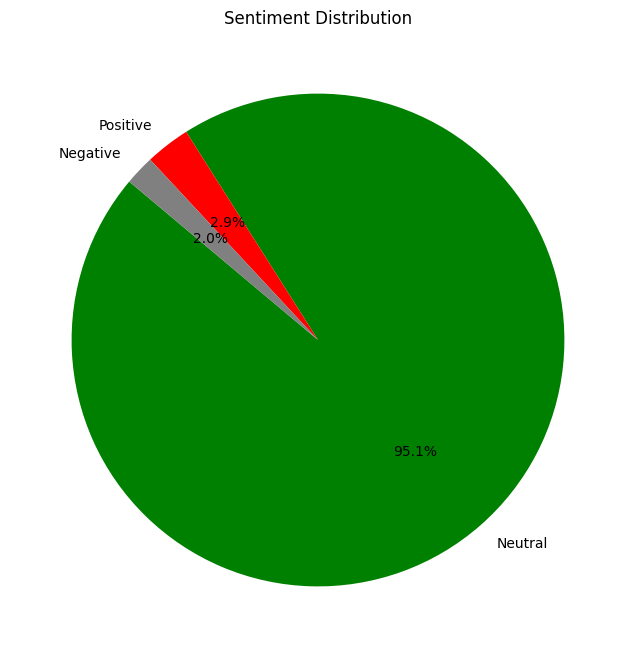

<Figure size 640x480 with 0 Axes>

In [86]:
sentiment_analysis.visualize_sentiment_distrbution(df)